<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Module 4:</span> Model Training</h1>
<hr>

At last, it's time to build our models! 

Remember, professional data scientists actually spend the bulk of their time on the 3 steps leading up to this one: 
1. Exploratory Analysis
2. Data Cleaning
3. Feature Engineering

Again, that's because **better data beats fancier algorithms**.

<br><hr id="toc">

### In this module...

First, we'll load our analytical base table from Module 2. 

Then, we'll go through the essential modeling steps:

1. [Split your dataset](#split)
2. [Build model pipelines](#pipelines)
3. [Declare hyperparameters to tune](#hyperparameters)
4. [Fit and tune models with cross-validation](#fit-tune)
5. [Evaluate metrics](#evaluate)
6. [Area under ROC curve](#auroc)

Finally, we'll save the best model to use in the next module. Since we've seen these steps in Project 2 already, we'll try to speed through most of them. However, we'll spend a little extra time on the last 2 steps because classification tasks require new metrics.

<br><hr>

### First, let's import libraries, recruit models, and load the ABT.

First, let's import the libraries that we'll need.

In [138]:
# print_function for compatibility with Python 3
from __future__ import print_function
# NumPy for numerical computing
import numpy as np
# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
import matplotlib.pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
# Scikit-Learn for Modeling
import sklearn
# Pickle for saving model files
import pickle

Next, let's import the algorithms we introduced in Module 3.

In [139]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Next, let's import the Scikit-Learn functions and helpers we'll need for this module.
* Remember, it's OK to just add more imports here as you need them and re-run this cell (it won't change anything else you've done).

In [140]:
# Function for splitting training and test set
from sklearn.model_selection import train_test_split
# Function for creating model pipelines
from sklearn.pipeline import make_pipeline
# For standardization
from sklearn.preprocessing import StandardScaler
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV
# Classification metrics (added later)
from sklearn.metrics import roc_curve, auc

Finally, let's read the analytical base table you saved at the end of Module 2.

In [12]:
# Load analytical base table from Module 2
abt_df = pd.read_csv('analytical_base_table.csv')

<span id="split"></span>
# 1. Split your dataset

Just as we did in Project 2, let's start by splitting our data into separate training and test sets. 

<br>
**First, separate the dataframe into separate objects for the target variable, <code style="color:steelblue">y</code>, and the input features, <code style="color:steelblue">X</code>.**

In [21]:
# Create separate object for target variable
y = abt_df.status

# Create separate object for input features
X = abt_df.drop('status', axis = 1)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,last_evaluation_missing,underperformer,unhappy,...,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,5.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,2.0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,3.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,2.0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,3.0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


**After you've imported the <code style="color:steelblue">train_test_split()</code> function, split <code style="color:steelblue">X</code> and <code style="color:steelblue">y</code> into training and test sets.**
* Pass in the argument <code style="color:steelblue">test_size=<span style="color:crimson">0.2</span></code> to set aside 20% of our observations for the test set.
* Pass in <code style="color:steelblue">random_state=<span style="color:crimson">1234</span></code> to set the random state for replicable results.
* **Important:** Also pass in the argument <code style="color:steelblue">stratify=<span style="color:crimson">df.status</span></code> in order to make sure the target variable's classes are balanced in each subset of data! This is **stratified random sampling**.
* Then, print the number of observations in each subset to check that it was done correctly.

In [29]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 1234, 
                                                    stratify = abt_df.status)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="pipelines"></span>
# 2. Build model pipelines

Next, let's set up preprocessing pipelines for each of our algorithms.

<br>
**Create a single <span style="color:royalblue">pipeline dictionary</span> with pipelines for each algorithm**.
* Use the keys:
    * <code style="color:crimson">'l1'</code> for $L_1$-regularized logistic regression
    * <code style="color:crimson">'l2'</code> for $L_2$-regularized logistic regression
    * <code style="color:crimson">'rf'</code> for random forest
    * <code style="color:crimson">'gb'</code> for gradient boosted tree.
* Each pipeline should standardize the data first.
* Remember to set <code style="color:steelblue">random_state=<span style="color:crimson">123</span></code> for each algorithm to ensure replicable results.

In [69]:
# Pipeline dictionary
pipelines = {
    'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)),
    'l2': make_pipeline(StandardScaler(), LogisticRegression(random_state=123)),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="hyperparameters"></span>
# 3. Declare hyperparameters to tune

Next, let's declare hyperparameters to tune.

<br>
**First, list the tunable hyperparameters of your $L_1$-regularized logistic regression pipeline.**

In [42]:
# List tuneable hyperparameters of our Logistic pipeline
pipelines['l1'].get_params()

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'ovr',
 'logisticregression__n_jobs': 1,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': 123,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscal

Let's declare the **hyperparameter grids** to tune.

In [46]:
# Logistic Regression hyperparameters
l1_hyperparams = {
    'logisticregression__C': np.linspace(1e-3, 1e3, 10)
}
l2_hyperparams = {
    'logisticregression__C': np.linspace(1e-3, 1e3, 10)
}

**Declare the hyperparameter grid for the random forest.**

In [49]:
# Random Forest hyperparameters
#look up the parameters first to know which ones to tune 
pipelines['rf'].get_params()
rf_hyperparams = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', .33]
}

**Declare the hyperparameter grid for the boosted tree.**

In [51]:
# Boosted Tree hyperparameters
#look up the parameters 
pipelines['gb'].get_params()
gb_hyperparams = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [.05, .1, .2], 
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

**Create a <code style="color:steelblue">hyperparameters</code> dictionary**.
* Use the same keys as in the <code style="color:steelblue">pipelines</code> dictionary.

In [53]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1': l1_hyperparams,
    'l2': l2_hyperparams,
    'rf': rf_hyperparams,
    'gb': gb_hyperparams
}

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="fit-tune"></span>
# 4. Fit and tune models with cross-validation

Now that we have our <code style="color:steelblue">pipelines</code> and <code style="color:steelblue">hyperparameters</code> dictionaries declared, we're ready to tune our models with **cross-validation**.

<br>
**Create a <code style="color:SteelBlue">fitted_models</code> dictionary that includes models that have been tuned using cross-validation.**
* The keys should be the same as those in the <code style="color:SteelBlue">pipelines</code> and <code style="color:SteelBlue">hyperparameters</code> dictionaries. 
* The values should be <code style="color:steelblue">GridSearchCV</code> objects that have been fitted to <code style="color:steelblue">X_train</code> and <code style="color:steelblue">y_train</code>.
* After fitting each model, print <code style="color:crimson">'{name} has been fitted.'</code> just to track the progress.
* (Optionally) You can set <code style="color:steelblue">n_jobs=<span style="color:crimson">-1</span></code> to use as many cores as available on your computer.

This step can take a few minutes, so please be patient.

In [59]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv = 10, n_jobs = -1)
    
    # Fit model on X_train, y_train
    model.fit(X = X_train, y = y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print('{} has been fitted'.format(name))


rf has been fitted
l2 has been fitted
gb has been fitted
l1 has been fitted


<span id="evaluate"></span>
# 5. Evaluate metrics

Finally, it's time to evaluate our models and pick the best one.

<br>
**First, display the <code style="color:steelblue">best\_score_</code> attribute for each fitted model.**

In [71]:
# Display best_score_ for each fitted model
for model in fitted_models:
    print(model, fitted_models[model].best_score_)

rf 0.979118535632
l2 0.844766305314
gb 0.975297671939
l1 0.844855162609


If you get different numbers, check to see that you've set the <code style="color:steelblue">random_state=</code> correctly for each of the models.

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="auroc"></span>
# 6. Area under ROC curve

**Area under ROC curve** is the most reliable metric for classification tasks.

<br>
**Add this import to the top of your Companion Workbook (good practice for keeping all your imports in one place.** 
* Remember to run the entire code cell afterward.

In [ ]:
# Classification metrics
from sklearn.metrics import roc_curve, auc

Before presenting the idea of an ROC curve, we must first discuss what a **confusion matrix** is. 

Let's see an example using our $L_1$-regularized logistic regression. 
* First, let's use <code style="color:steelblue">.predict()</code> to get the predicted classes directly.

In [79]:
# Predict classes using L1-regularized logistic regression 
l1_pred = fitted_models['l1'].predict(X_test)

# Display first 5 predictions
l1_pred[:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0])

* Next, let's display the confusion matrix:

In [81]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix for y_test and pred
print(confusion_matrix(y_true= y_test, y_pred = pred))

[[1963  178]
 [ 216  457]]


Remember, we can predict a **probability** for each class using <code style="color:steelblue">.predict_proba()</code>, instead of the class directly.

For example:

In [86]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models['l1'].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [Class[1] for Class in pred]

# Display first 5 predictions
pred[:10]

[0.034798324101997756,
 0.0078241180596906237,
 0.0075538297431329516,
 0.060425118971431414,
 0.059395978166606064,
 0.5684667219849685,
 0.11494004717877582,
 0.59539927528683911,
 0.68799435135345421,
 0.18797582006806832]

Let's calculate the ROC curve using the <code style="color:steelblue">roc_curve()</code> function that we imported earlier.

In [92]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=pred)

We can throw these into a DataFrame for convenience and look at the last 10:

In [108]:
# Store fpr, tpr, thresholds in DataFrame and display last 10
pd.DataFrame(data = {'FPR': fpr, 'TPR': tpr, 'THRESHOLDS': thresholds}).tail(10)

,FPR,THRESHOLDS,TPR
512,0.766464,0.010519,0.992571
513,0.768800,0.010306,0.992571
514,0.768800,0.010289,0.994056
515,0.810836,0.007245,0.994056
516,0.810836,0.007215,0.995542
517,0.922933,0.002296,0.995542
518,0.922933,0.002284,0.998514
519,0.950490,0.001451,0.998514
520,0.950490,0.001450,1.000000
521,1.000000,0.000034,1.000000


As you can see, as you decrease the threshold, both the false positive rate **and** the true positive rate increase.

We can plot the entire curve.

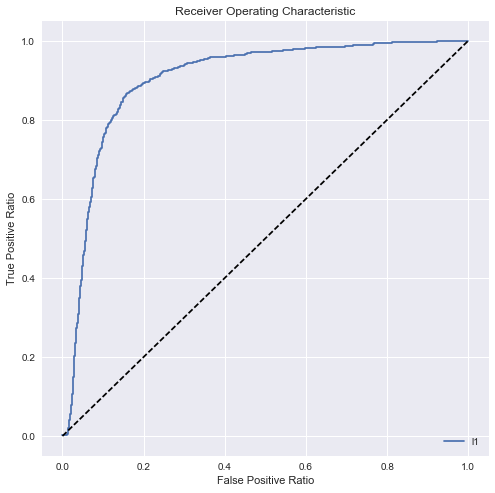

In [116]:
# Initialize figure
figure = plt.figure(figsize=(8,8), edgecolor='red')
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label = 'l1')
plt.legend(loc = 'lower right')

# Diagonal 45 degree line
plt.plot([0,1], [0,1], 'k--')

# Axes limits and labels
plt.ylabel('True Positive Ratio')
plt.xlabel('False Positive Ratio')


To calculate AUROC, use the <code style="color:steelblue">auc()</code> function we imported earlier in conjunction with the <code style="color:steelblue">roc_curve()</code> function.

In [120]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=pred)
# Calculate AUROC
print(auc(x=fpr, y = tpr))

0.900945455353


Now that we've taken a detour to dive into some of the intuition behind AUROC, let's calculate it for each of our fitted models on the test set.

<br>
**Using a <code style="color:SteelBlue">for</code> loop, print the performance of each model in <code style="color:SteelBlue">fitted_models</code> on the test set.**
* Print the <code style="color:SteelBlue">auc</code> of the <code style="color:SteelBlue">roc_curve</code>.
* Label the output with the name of the algorithm. For example:

<pre style="color:crimson">
rf 0.991520189216
</pre>

In [133]:
# Code here
for model in fitted_models:
    #create class probabilities
    pred = fitted_models[model].predict_proba(X_test)
    pred = [Class[1] for Class in pred]
    
    #create fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    
    #calculate auc
    mod_auc = auc(fpr, tpr)
    print(model, mod_auc)
    
print('\n')    
for model in fitted_models: 
    print(model, fitted_models[model].best_score_)

rf 0.992145495883
l2 0.900944067325
gb 0.988985302864
l1 0.900945455353


rf 0.979118535632
l2 0.844766305314
gb 0.975297671939
l1 0.844855162609


**Finally, save the winning <code style="color:steelblue">Pipeline</code> object into a pickle file.**
* Just save the <code style="color:steelblue">Pipeline</code>, not the <code style="color:steelblue">GridSearchCV</code> object.
* **Hint:** Remember the <code style="color:steelblue">.best\_estimator_</code> attribute?

In [141]:
# Save winning model as final_model.pkl
fitted_models['rf'].best_estimator_
with open('fitted_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<br>
## Next Steps

Congratulations for making through Project 3's Model Training module!

As a reminder, here are a few things you did in this module:
* You split your dataset into training and test sets.
* You set up model pipelines and hyperparameter grids.
* You tuned your models using cross-validation.
* You learned about how AUROC is a more effective metric for classification than simple accuracy.
* And finally, you saved the winning model.

In the next module, <span style="color:royalblue">Module 5: Project Delivery</span>, we'll see how you can go the extra mile in terms of project delivery. That includes preparing to apply your model to raw data and packaging it up into an executable script.

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>